In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [3]:
data = pd.read_csv('data/kobe.csv')

In [6]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [ ]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

Селекторы полей по типу данных

In [21]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

Посмотрим статистику по пропущенным данными

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

Посмотрим на статистику по числовым полям

In [17]:
data.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


Сразу можно отбросить 4 столбца с идентификаторами, они нужны для различных статистических запросов, но для пресказания поля shot_made_flag явно не нужны

In [18]:
data = data.loc[:, ~data.columns.isin(['game_event_id', 'game_id', 'team_id', 'shot_id'])]

Посмотрим строковые поля

In [22]:
data[cat_selector(data)].describe(include='all')

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,20,2,6,7,5,1,1559,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,2318,24271,13455,12625,9398,30697,50,1020,1978


Поле team_name можно смело отбрасывать, т.к. вся выборка относится к одной команде.

In [23]:
data = data.loc[:, ~data.columns.isin(['team_name'])]

Посмотрим значения текстовых полей

In [24]:
data.action_type.unique()

array(['Jump Shot', 'Driving Dunk Shot', 'Layup Shot',
       'Running Jump Shot', 'Driving Layup Shot', 'Reverse Layup Shot',
       'Reverse Dunk Shot', 'Slam Dunk Shot', 'Turnaround Jump Shot',
       'Tip Shot', 'Running Hook Shot', 'Alley Oop Dunk Shot',
       'Dunk Shot', 'Alley Oop Layup shot', 'Running Dunk Shot',
       'Driving Finger Roll Shot', 'Running Layup Shot',
       'Finger Roll Shot', 'Fadeaway Jump Shot', 'Follow Up Dunk Shot',
       'Hook Shot', 'Turnaround Hook Shot', 'Running Tip Shot',
       'Jump Hook Shot', 'Running Finger Roll Shot', 'Jump Bank Shot',
       'Turnaround Finger Roll Shot', 'Hook Bank Shot',
       'Driving Hook Shot', 'Running Reverse Layup Shot',
       'Driving Finger Roll Layup Shot', 'Fadeaway Bank shot',
       'Pullup Jump shot', 'Finger Roll Layup Shot',
       'Turnaround Fadeaway shot', 'Driving Reverse Layup Shot',
       'Driving Slam Dunk Shot', 'Step Back Jump shot',
       'Reverse Slam Dunk Shot', 'Turnaround Bank shot',
   

In [25]:
data.combined_shot_type.unique()

array(['Jump Shot', 'Dunk', 'Layup', 'Tip Shot', 'Hook Shot', 'Bank Shot'],
      dtype=object)

combined_shot_type скорее всего является обобщением поля action_type, можно исключить, но попробуем закодировать через One-Hot Encoding

In [26]:
data.season.unique()

array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '1996-97', '1997-98',
       '1998-99', '1999-00'], dtype=object)

In [34]:
data.game_date.unique()

array(['2000-10-31', '2000-11-01', '2000-11-04', ..., '2000-06-14',
       '2000-06-16', '2000-06-19'], dtype=object)

Сезон тоже можно исключить, т.к. можно вычислить из даты игры

In [27]:
data.shot_type.unique()

array(['2PT Field Goal', '3PT Field Goal'], dtype=object)

In [28]:
data.shot_zone_area.unique()

array(['Right Side(R)', 'Left Side(L)', 'Left Side Center(LC)',
       'Right Side Center(RC)', 'Center(C)', 'Back Court(BC)'],
      dtype=object)

In [29]:
data.shot_zone_basic.unique()

array(['Mid-Range', 'Restricted Area', 'In The Paint (Non-RA)',
       'Above the Break 3', 'Right Corner 3', 'Backcourt',
       'Left Corner 3'], dtype=object)

In [30]:
data.shot_zone_range.unique()

array(['16-24 ft.', '8-16 ft.', 'Less Than 8 ft.', '24+ ft.',
       'Back Court Shot'], dtype=object)

Характеристики ударов можно закодировать через One-Hot Encoding

In [32]:
data.matchup.unique()

array(['LAL @ POR', 'LAL vs. UTA', 'LAL @ VAN', 'LAL vs. LAC',
       'LAL @ HOU', 'LAL @ SAS', 'LAL vs. HOU', 'LAL vs. DEN',
       'LAL @ SAC', 'LAL @ DEN', 'LAL vs. CHI', 'LAL vs. GSW',
       'LAL vs. MIN', 'LAL @ LAC', 'LAL vs. IND', 'LAL @ SEA',
       'LAL vs. SAS', 'LAL vs. DAL', 'LAL vs. PHI', 'LAL @ GSW',
       'LAL vs. SEA', 'LAL vs. DET', 'LAL vs. MIL', 'LAL vs. VAN',
       'LAL @ TOR', 'LAL @ MIA', 'LAL @ DAL', 'LAL vs. POR', 'LAL @ PHX',
       'LAL vs. CLE', 'LAL @ UTA', 'LAL vs. MIA', 'LAL vs. NJN',
       'LAL @ NYK', 'LAL @ CLE', 'LAL @ MIN', 'LAL vs. CHH',
       'LAL vs. SAC', 'LAL vs. PHX', 'LAL @ NJN', 'LAL @ PHI',
       'LAL @ CHH', 'LAL @ IND', 'LAL vs. TOR', 'LAL @ DET', 'LAL @ WAS',
       'LAL @ ORL', 'LAL @ ATL', 'LAL @ MIL', 'LAL vs. NYK',
       'LAL vs. MEM', 'LAL vs. ORL', 'LAL @ MEM', 'LAL @ CHI',
       'LAL vs. WAS', 'LAL vs. ATL', 'LAL vs. BOS', 'LAL @ BOS',
       'LAL vs. NOH', 'LAL @ NOH', 'LAL @ UTH', 'LAL vs. SAN',
       'LAL @ NOK', 'LAL @ 

In [33]:
data.opponent.unique()

array(['POR', 'UTA', 'VAN', 'LAC', 'HOU', 'SAS', 'DEN', 'SAC', 'CHI',
       'GSW', 'MIN', 'IND', 'SEA', 'DAL', 'PHI', 'DET', 'MIL', 'TOR',
       'MIA', 'PHX', 'CLE', 'NJN', 'NYK', 'CHA', 'WAS', 'ORL', 'ATL',
       'MEM', 'BOS', 'NOH', 'NOP', 'OKC', 'BKN'], dtype=object)

Поле matchup явно является производным от команды и оппонентов, можно так же исключить

In [38]:
data = data.loc[:, ~data.columns.isin(['season', 'matchup'])]

lon/lat и loc_x/loc_y похожи на координаты, посмотрим на их связь

Text(0.5, 1.0, 'scatter plot of loc_x and loc_y values')

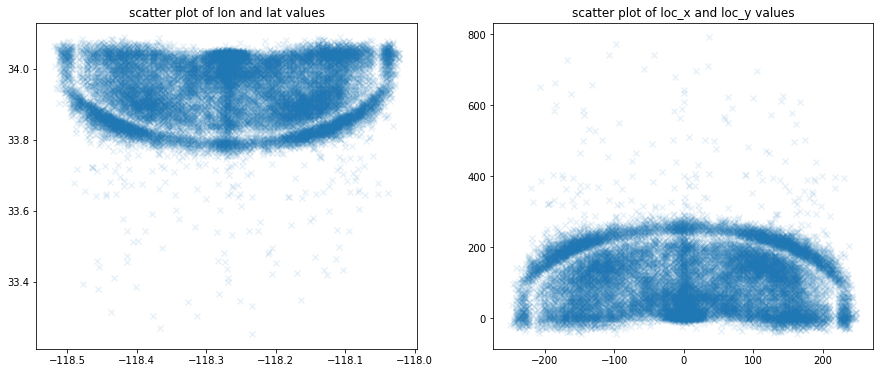

In [250]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.scatter(df.lon, df.lat, marker='x', alpha=0.1)
plt.title('scatter plot of lon and lat values')
plt.subplot(122)
plt.scatter(df.loc_x, df.loc_y, marker='x', alpha=0.1)
plt.title('scatter plot of loc_x and loc_y values')

Можно исключить одну из пар. lon/lat скорее всего координаты, а loc_x/loc_y производная от них. Оставим координаты

In [251]:
data = data.loc[:, ~data.columns.isin(['loc_x', 'loc_y'])]

Посмотрим, что осталось

In [252]:
data.describe(include='all')

,action_type,combined_shot_type,lat,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,opponent
count,30697,30697,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,30697,30697,30697,30697,30697,30697
unique,57,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,6,7,5,1559,33
top,Jump Shot,Jump Shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,2016-04-13,SAS
freq,18880,23485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24271,13455,12625,9398,50,1978
mean,NaN,NaN,33.953192,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.087791,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,33.253300,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,33.884300,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,33.970300,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,34.040300,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
data[data.shot_made_flag.isna()]

,action_type,combined_shot_type,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,opponent
0,Jump Shot,Jump Shot,33.9723,167,72,-118.1028,10,1,0,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,2000-10-31,POR
7,Jump Shot,Jump Shot,34.0163,1,28,-118.2688,8,3,0,5,2,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-10-31,POR
16,Driving Layup Shot,Layup,34.0443,0,0,-118.2698,0,1,0,1,0,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-11-01,UTA
19,Driving Layup Shot,Layup,34.0443,0,0,-118.2698,10,3,0,46,0,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-11-01,UTA
32,Jump Shot,Jump Shot,33.9683,163,76,-118.1068,11,1,0,26,17,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,2000-11-04,VAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30668,Jump Shot,Jump Shot,33.8223,-23,222,-118.2928,7,4,1,27,22,NaN,2PT Field Goal,Center(C),Mid-Range,16-24 ft.,2000-06-16,IND
30680,Tip Shot,Tip Shot,34.0443,0,0,-118.2698,0,2,1,40,0,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-06-19,IND
30682,Running Jump Shot,Jump Shot,33.9963,-68,48,-118.3378,11,3,1,30,8,NaN,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,2000-06-19,IND
30686,Running Jump Shot,Jump Shot,33.9513,16,93,-118.2538,5,3,1,37,9,NaN,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,2000-06-19,IND


Пропуски есть только в целевом поле shot_made_flag, поэтому разделим выборку на две части: Записи с пропущенными значениями будут рабочей выборкой, остальное - обучающей

In [253]:
data_t = data[data.shot_made_flag.notnull()]
data_p = data[data.shot_made_flag.isnull()]

X_train = data_t.loc[:, ~data_t.columns.isin(['shot_made_flag'])]
Y_train = data_t['shot_made_flag']

X_pred = data_p.loc[:, ~data_p.columns.isin(['shot_made_flag'])]

Оценим важность оставшихся признаков через дерево решений. Для этого категориальные поля преобразуем через LabelEncoder

In [254]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [255]:
df = X_train[X_train.columns]
le_cols = cat_selector(df)
df[le_cols] = df[le_cols].apply(lambda col: le.fit_transform(col))

In [256]:
clf = RandomForestRegressor().fit(df, Y_train)

In [257]:
feat = dict(sorted(dict(zip(df.columns, clf.feature_importances_)).items(),
                   key=lambda x: x[1], reverse=False))

''

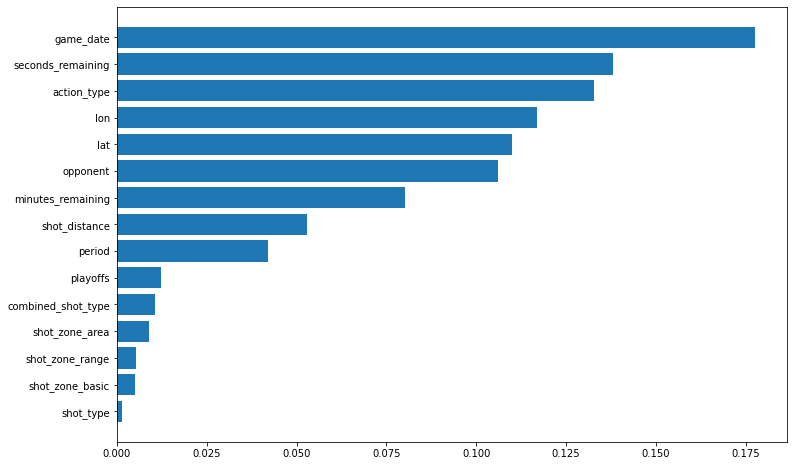

In [258]:
plt.figure(figsize=(12, 8))
plt.barh(np.arange(len(feat)), feat.values())
plt.yticks(np.arange(len(feat)),feat.keys())
''

Попробуем последние 6 признаков закодировать через one-hot encoding

In [259]:
ohe_cols = list(feat.keys())[:6]

In [260]:
df = pd.get_dummies(df, columns=ohe_cols)

In [261]:
clf = RandomForestRegressor().fit(df, Y_train)

In [262]:
feat = dict(sorted(dict(zip(df.columns, clf.feature_importances_)).items(),
                   key=lambda x: x[1], reverse=False))

''

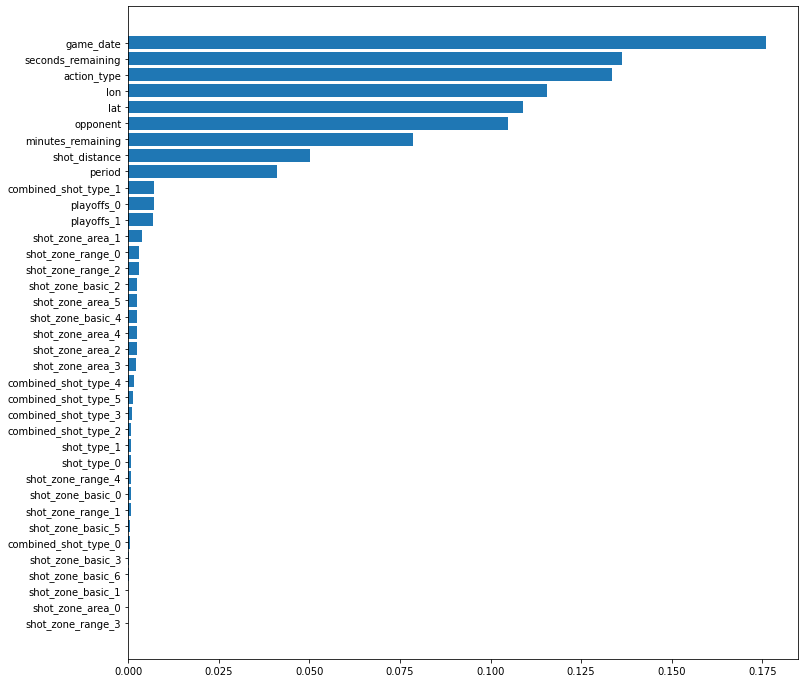

In [263]:
plt.figure(figsize=(12, 12))
plt.barh(np.arange(len(feat)), feat.values())
plt.yticks(np.arange(len(feat)),feat.keys())
''

Как видим, существенно значимость не изменилась, поэтому оставляем первые 9 признаков

In [264]:
feat_cols = list(feat.keys())[-9:]
feat_cols

['period',
 'shot_distance',
 'minutes_remaining',
 'opponent',
 'lat',
 'lon',
 'action_type',
 'seconds_remaining',
 'game_date']

In [279]:
df = X_train[feat_cols]
le_cols = cat_selector(df)
df[le_cols] = df[le_cols].apply(lambda col: le.fit_transform(col))

Посмотрим важность признаков с точки зрения методов L1-регуляризации

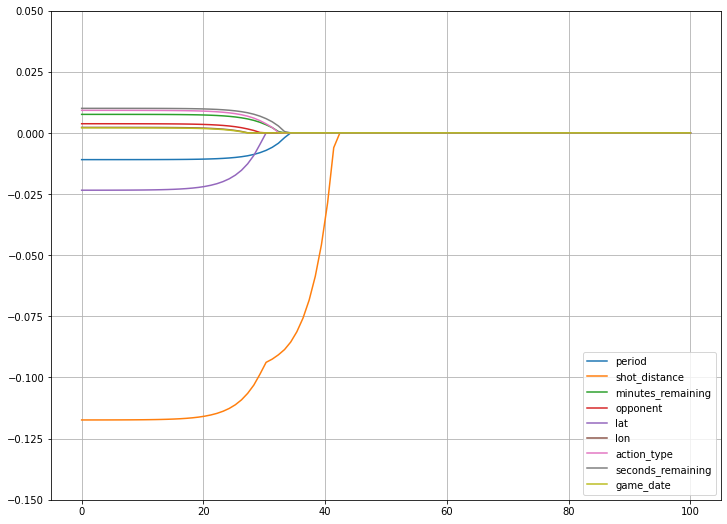

In [305]:
from sklearn.linear_model import  Lasso # линейная модель с L1-регуляризацией
from sklearn.preprocessing import StandardScaler

X_sc = StandardScaler().fit_transform(df) # преобразование данных
lg_l,pred_l = [], []

list_l=list(2**np.linspace(-20,20,100))

for i in range(len(list_l)):
    m_l = Lasso(alpha=list_l[i]).fit(X_sc, Y_train)
    lg_l.append(m_l)
    pred_l.append(m_l.coef_)

# рисуем отмасштабированные признаки на одном графике
plt.figure(figsize=(12,9))
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    plt.plot(x_l,np.sign(i)*np.abs(i)) 
plt.ylim(-0.15,0.05)  
plt.legend(df.columns)      
plt.grid()

Как видно, самым важным оказывается признак shot_distance.

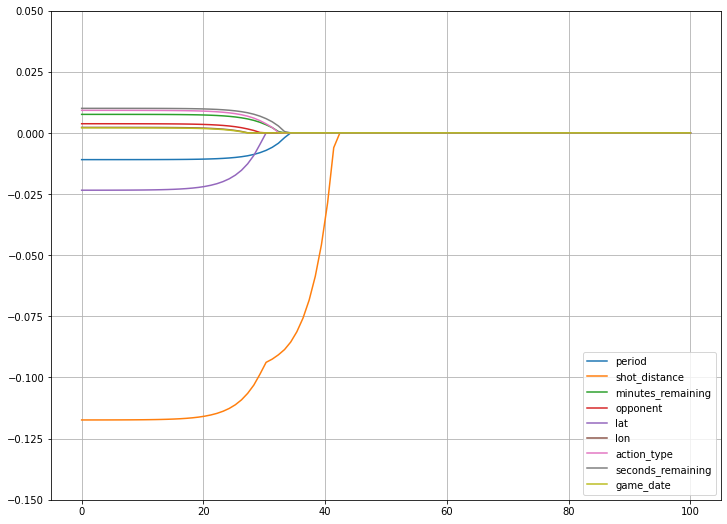

In [306]:
from sklearn.linear_model import  RidgeCV # линейная модель с L1-регуляризацией
from sklearn.preprocessing import StandardScaler

X_sc = StandardScaler().fit_transform(df) # преобразование данных
lg_l,pred_l = [], []

list_l=list(2**np.linspace(-20,20,100))

for i in range(len(list_l)):
    m_l = Lasso(alpha=list_l[i]).fit(X_sc, Y_train)
    lg_l.append(m_l)
    pred_l.append(m_l.coef_)

# рисуем отмасштабированные признаки на одном графике
plt.figure(figsize=(12,9))
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    plt.plot(x_l,np.sign(i)*np.abs(i)) 
plt.ylim(-0.15,0.05)  
plt.legend(df.columns)      
plt.grid()

Для модели RidgeCV получается такой же график